In [1]:
# switch to the project directory
%cd ..
# working directory should be ../FSE

c:\Users\admin\Desktop\research\pdi


In [2]:
import sys
import os
module_path = os.path.abspath('src')

if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from pdi.data.preparation import FeatureSetPreparation, MeanImputation, DeletePreparation, RegressionImputation, EnsemblePreparation

EXPERIMENTS = {
    "Mean": {
        "all": MeanImputation,
        "complete_only": DeletePreparation,
    },
    "Regression": {
        "all": RegressionImputation,
        "complete_only": DeletePreparation,
    },
    "Ensemble": {
        "all": EnsemblePreparation,
        "complete_only": lambda: EnsemblePreparation(complete_only=True),
    },
    "FSE": {
        "all": FeatureSetPreparation,
        "complete_only":  lambda: FeatureSetPreparation(complete_only=True),
    },
    "Delete": {
        "complete_only": DeletePreparation
    },
}

In [4]:
import torch

device = torch.device("cuda")

100%|██████████| 600/600 [00:09<00:00, 63.46it/s] 


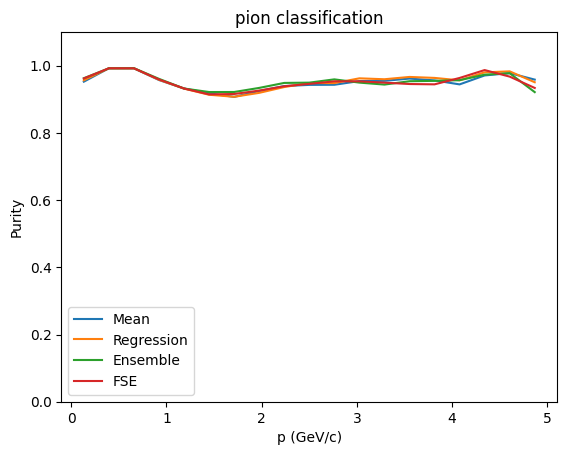

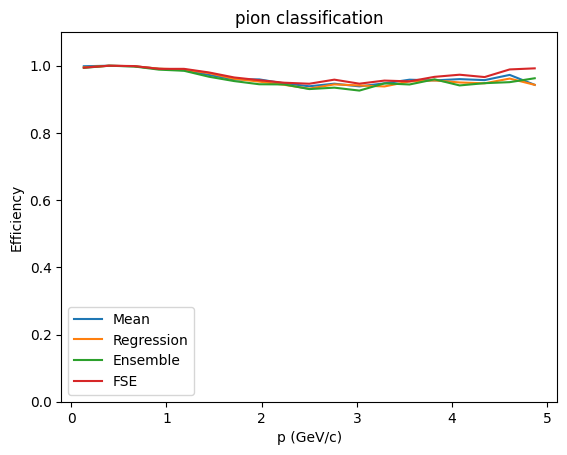

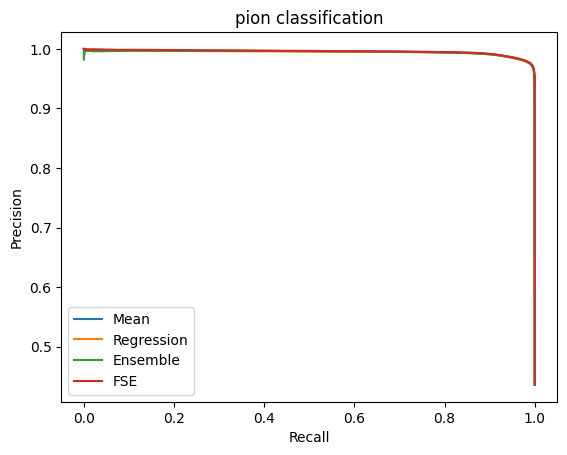

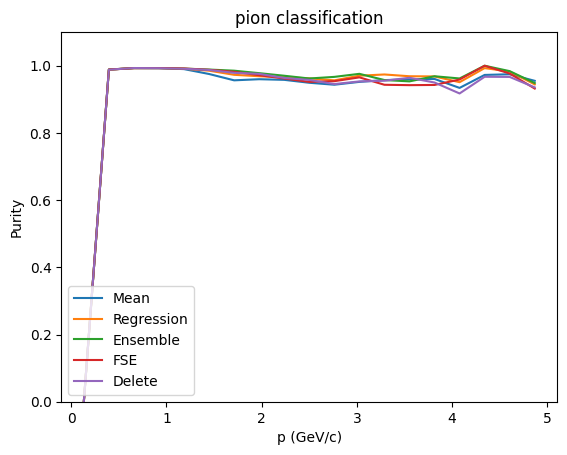

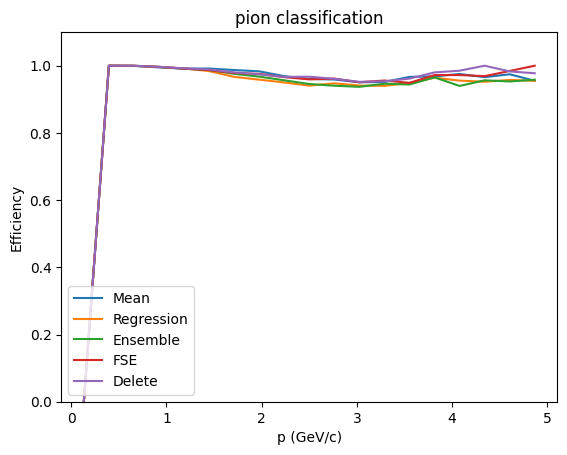

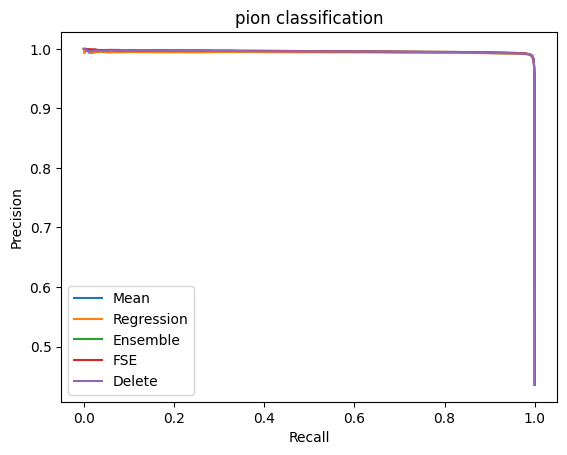

100%|██████████| 600/600 [00:09<00:00, 62.81it/s] 


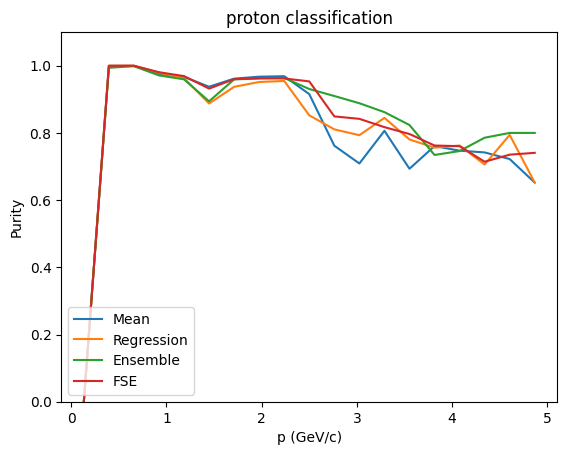

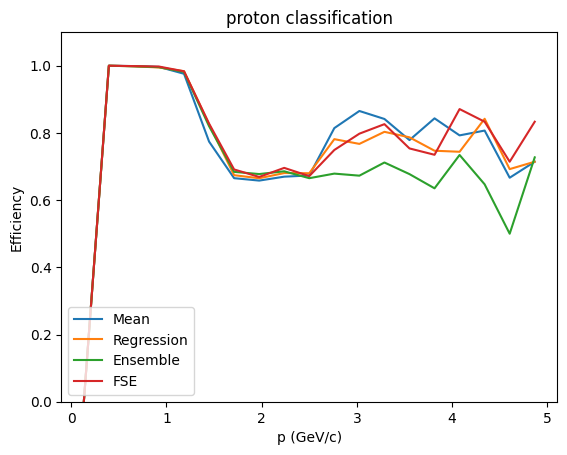

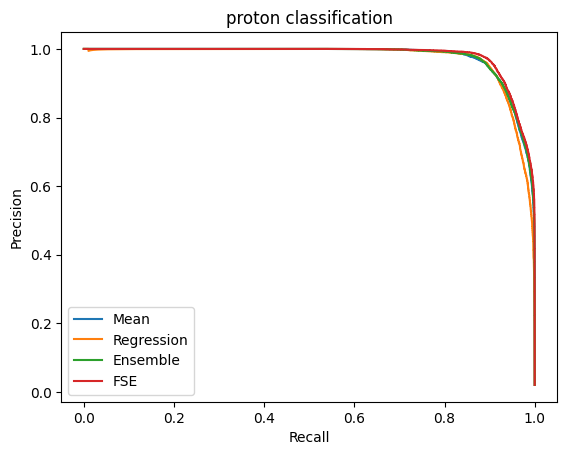

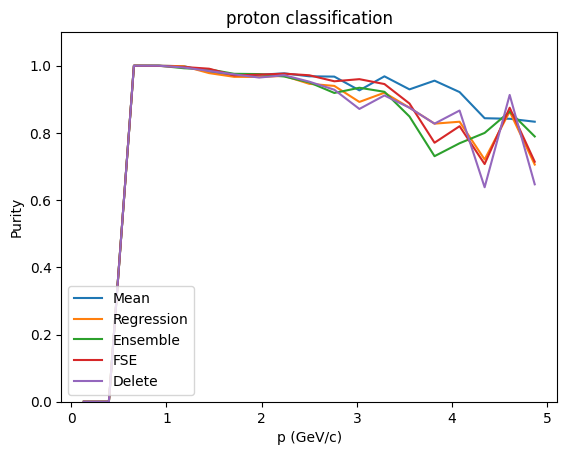

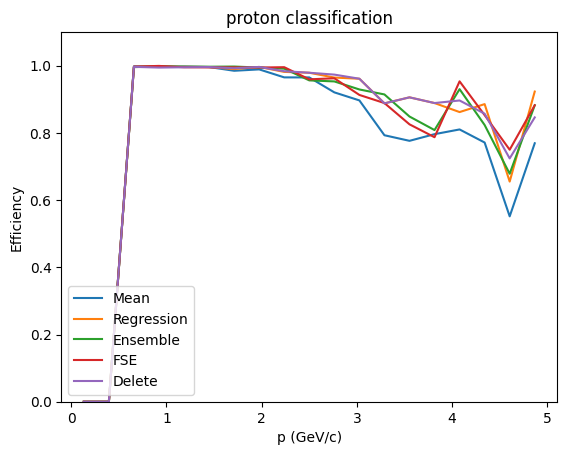

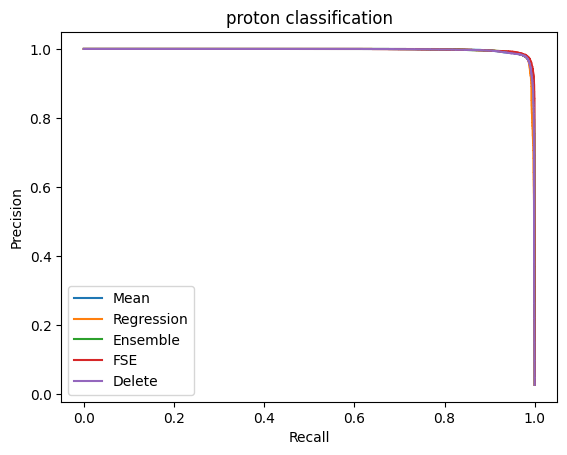

100%|██████████| 600/600 [00:07<00:00, 77.53it/s] 


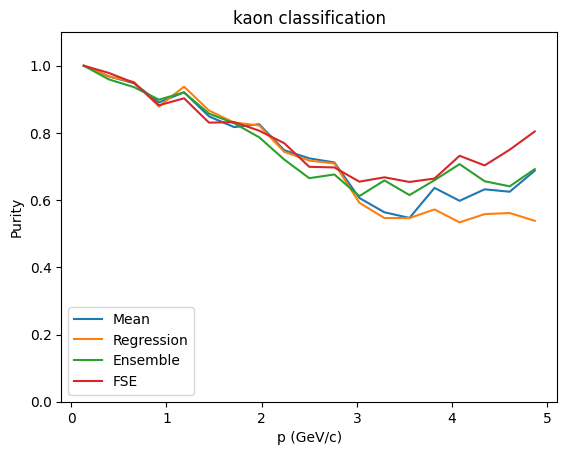

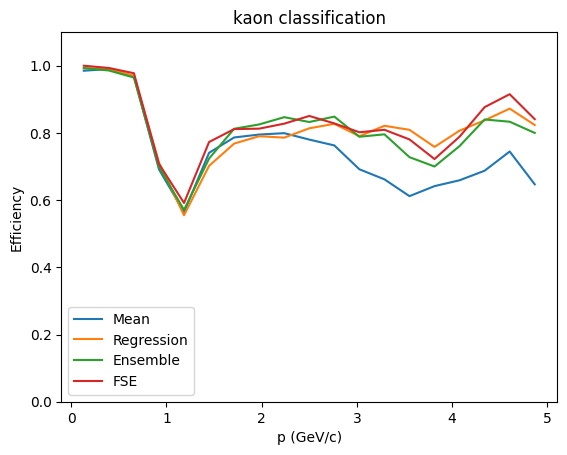

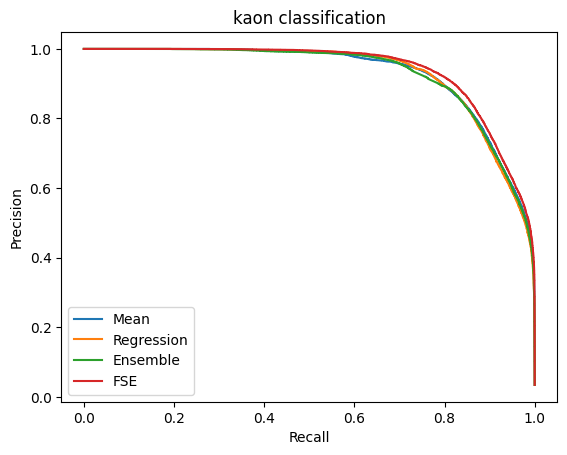

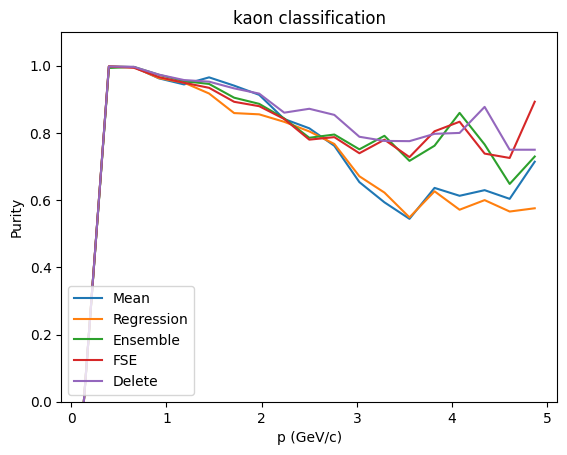

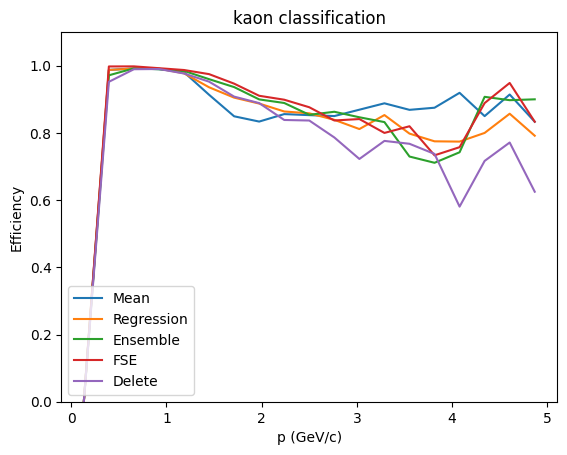

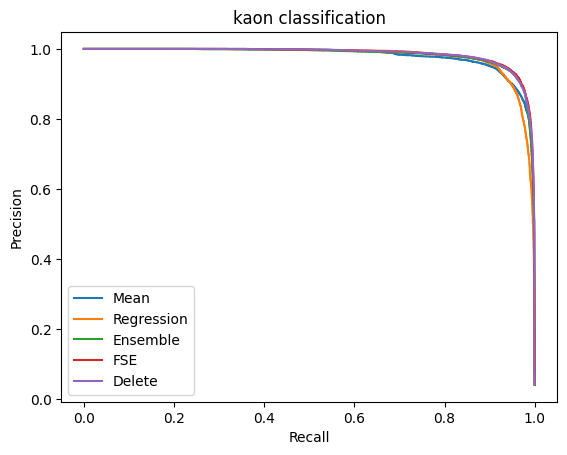

100%|██████████| 600/600 [00:07<00:00, 76.49it/s] 


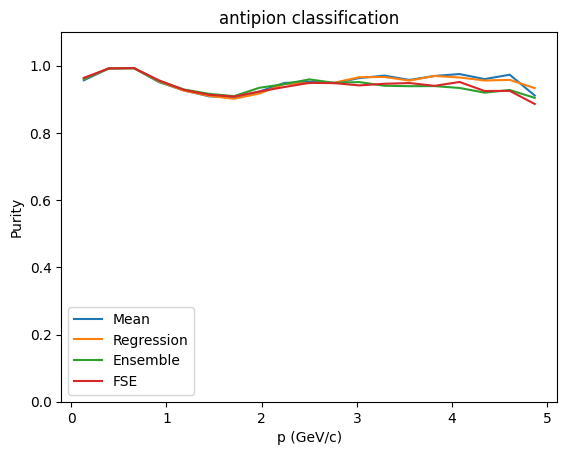

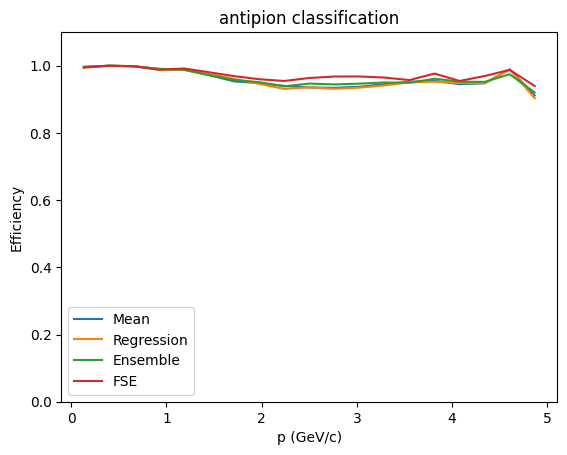

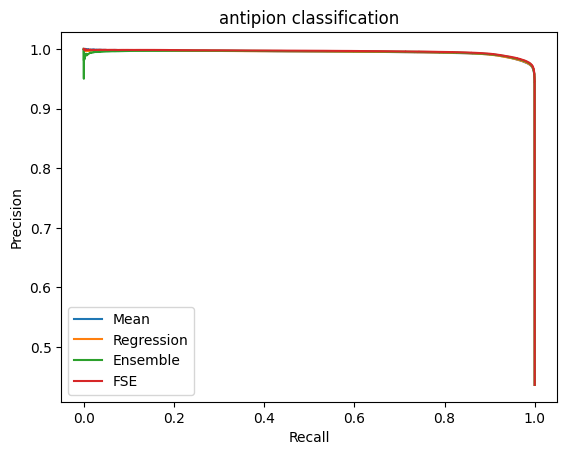

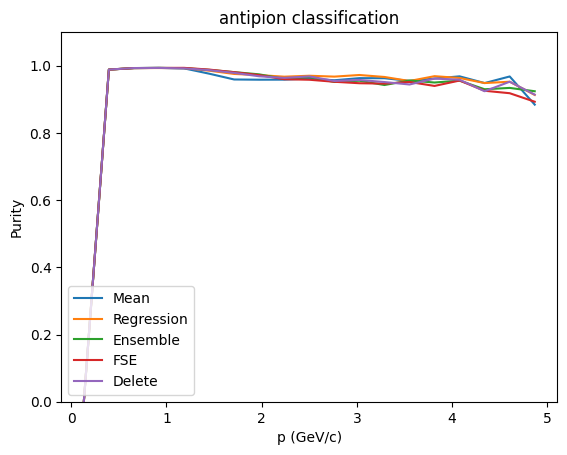

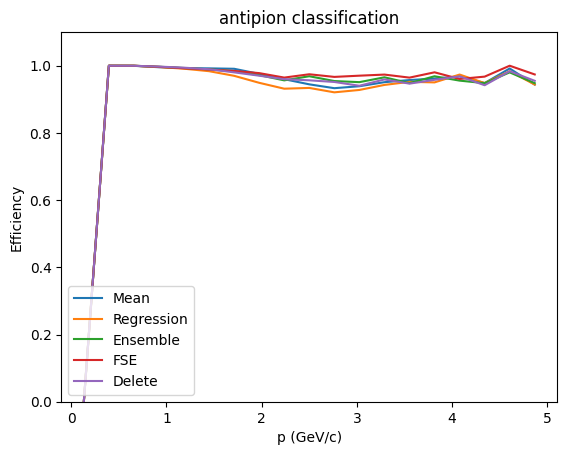

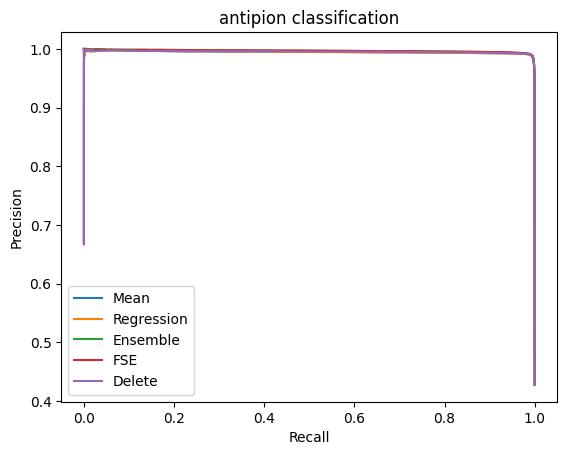

100%|██████████| 600/600 [00:08<00:00, 74.67it/s] 


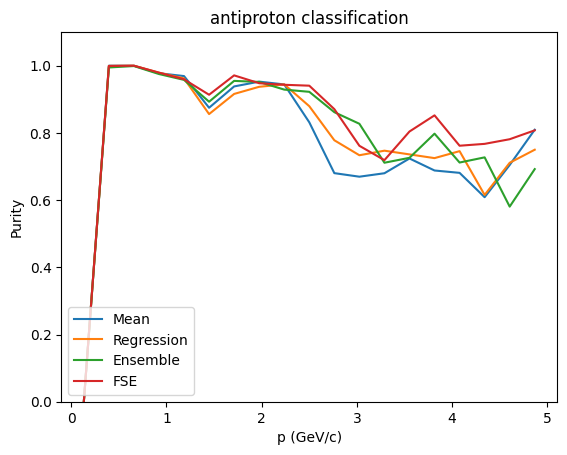

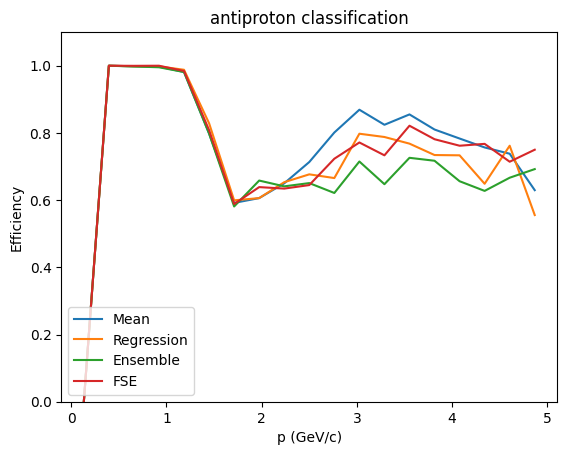

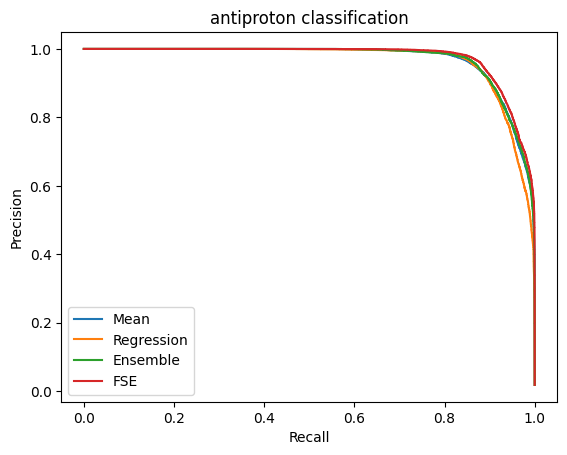

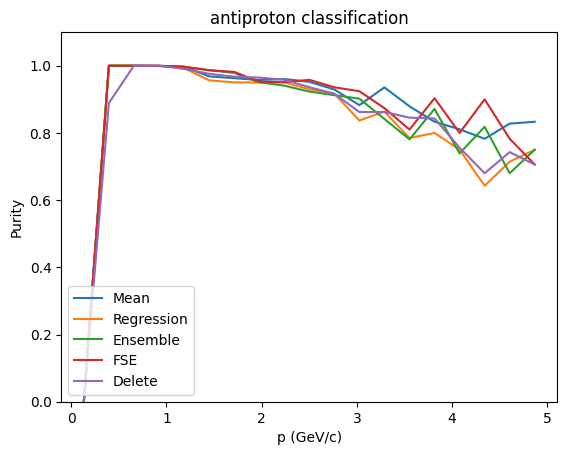

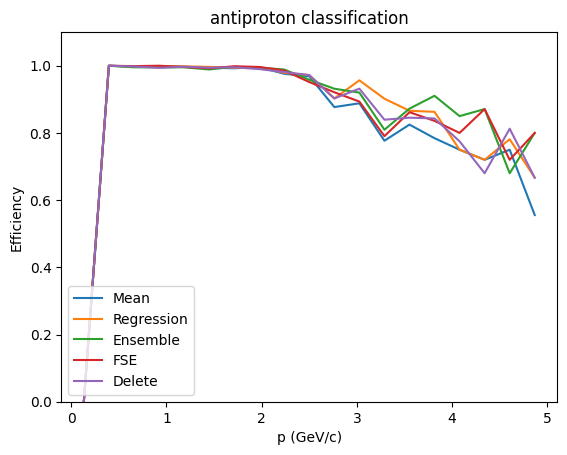

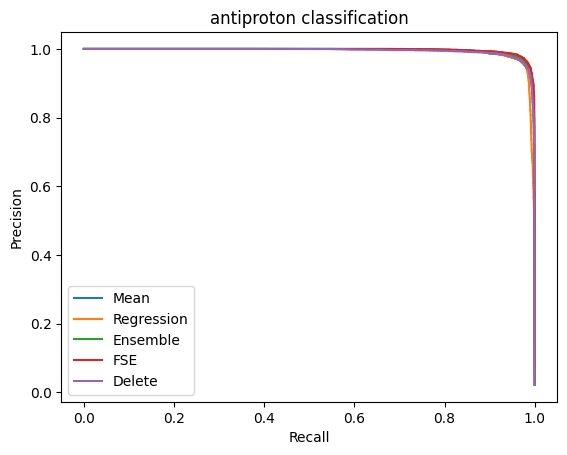

100%|██████████| 600/600 [00:10<00:00, 57.98it/s] 


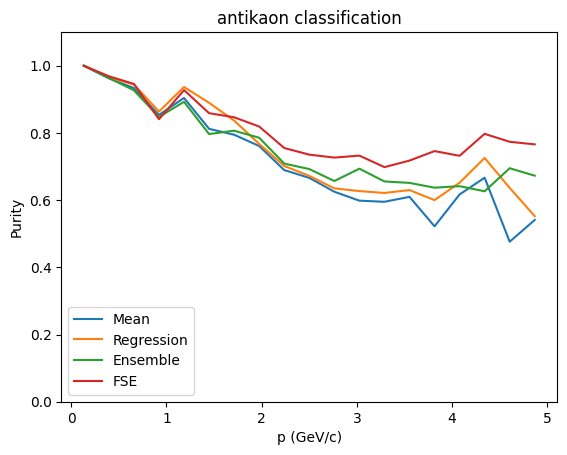

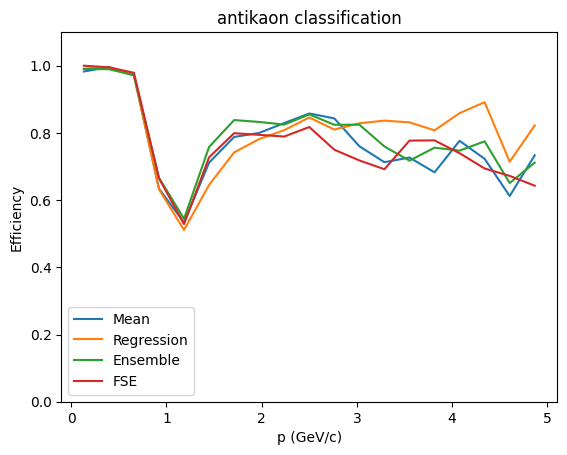

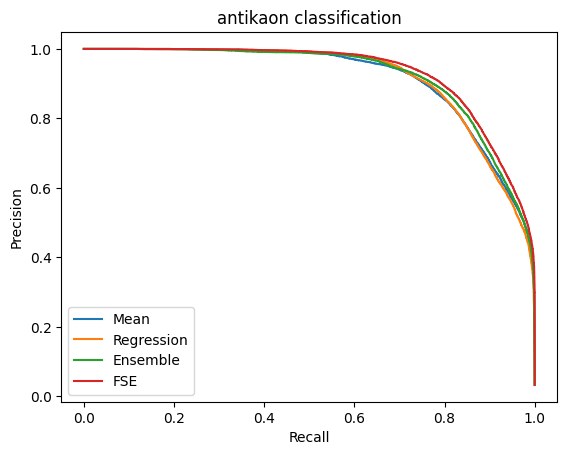

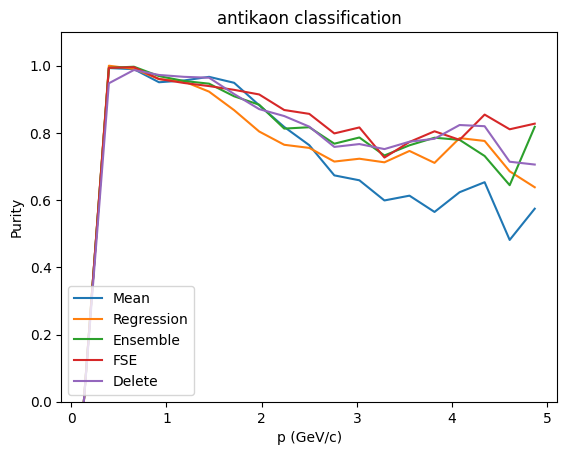

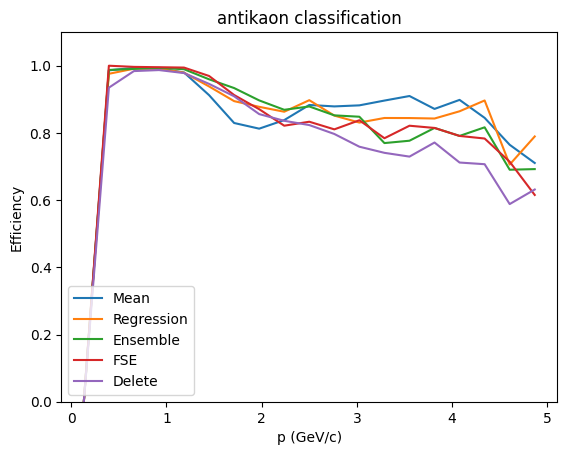

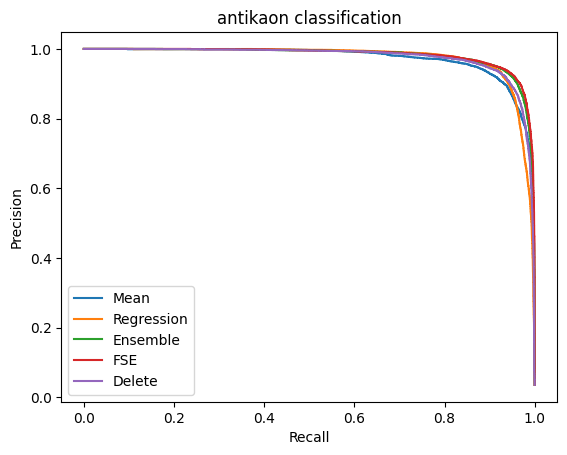

data                        all                     complete_only            \
metric                precision    recall        f1     precision    recall   
particle   model                                                              
pion       Mean        0.971797  0.993406  0.982483      0.986202  0.994536   
           Regression  0.972328  0.993095  0.982602      0.988491  0.992021   
           Ensemble     0.97449   0.99143  0.982887      0.989489  0.992854   
           FSE         0.973391  0.993739   0.98346      0.988412  0.994127   
           Delete           NaN       NaN       NaN      0.988351  0.994573   
proton     Mean        0.955887  0.892729  0.923229      0.981726  0.973736   
           Regression  0.951979  0.897333  0.923849      0.972107  0.984094   
           Ensemble    0.960674  0.889507  0.923722       0.97571  0.981792   
           FSE         0.964784  0.900927  0.931763       0.97989  0.982525   
           Delete           NaN       NaN       NaN 

C:\Users\admin\AppData\Local\Temp\ipykernel_4228\1283997604.py:89: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  metric_results.to_latex(f"reports/figures/comparison/metrics.tex")


OSError: Cannot save file into a non-existent directory: 'reports\figures\comparison'

In [5]:
%matplotlib inline

from pdi.constants import PARTICLES_DICT, TARGET_CODES, NUM_WORKERS, P_RANGE, P_RESOLUTION
from pdi.data.types import Split, Additional
from pdi.evaluate import get_predictions_and_data, calculate_precision_recall

import os
import pandas as pd
import numpy as np
from pdi.visualise import (
    plot_purity_comparison,
    plot_efficiency_comparison,
    plot_precision_recall_comparison,
)


particle_names = [PARTICLES_DICT[i] for i in TARGET_CODES]
model_names = EXPERIMENTS.keys()
metrics = ["precision", "recall", "f1"]
data_types = ["all", "complete_only"]

metric_results = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [particle_names, model_names], names=["particle", "model"]
        ),
    columns=pd.MultiIndex.from_product(
        [data_types, metrics], names=["data", "metric"]
        ),
    )

prediction_data = {}

for target_code in TARGET_CODES:
    particle_name = PARTICLES_DICT[target_code]
    for experiment_name, exp_dict in EXPERIMENTS.items():
        model = torch.load(f"models/{experiment_name}/{target_code}").to(device)
        batch_size = 512
        p_min, p_max = P_RANGE
        p_range = np.linspace(p_min, p_max, P_RESOLUTION)
        thresholds = [((p_low, p_high), model.thres) for (p_low, p_high) in zip(p_range[:-1], p_range[1:])]

        prediction_data[experiment_name] = {}
        for data_type, data_prep in exp_dict.items():
            test_loader, = data_prep().prepare_dataloaders(batch_size, NUM_WORKERS, [Split.TEST])
            
            targets, predictions, add_data = get_predictions_and_data(
                model, test_loader, device
            )

            selected = predictions > model.thres
            binary_targets = targets == target_code

            true_positives = int(np.sum(selected & binary_targets))
            selected_positives = int(np.sum(selected))
            positives = int(np.sum(binary_targets))

            precision, recall, _, _ = calculate_precision_recall(true_positives, selected_positives, positives)
            f1 = 2 * precision * recall / (precision + recall + np.finfo(float).eps)

            metric_results.loc[(particle_name, experiment_name), data_type] = precision, recall, f1
            
            # save_dir = f"reports/figures/{experiment_name}/{target_code}"
            # os.makedirs(save_dir, exist_ok=True)
            # selected = predictions > model.thres
            # plot_selected_particles(particle_name, selected, fP, fTPCSignal, "fTPCSignal", 15, save_dir)
            # plot_selected_particles(particle_name, selected, fP, fBeta, "fBeta", 1.5, save_dir)
            # plot_contamination(particle_name, targets, selected, fP, 20, p_min, p_max, save_dir)

            prediction_data[experiment_name][data_type] = {
                "targets": binary_targets,
                "predictions": predictions,
                "momentum": add_data[Additional.fP.name],
                "thresholds": thresholds
            }

    for data_type in data_types:
        data = {}
        for exp_name, exp_dict in prediction_data.items():
            if data_type in exp_dict:
                data[exp_name] = exp_dict[data_type]

        save_dir = f"reports/figures/comparison_{data_type}/{target_code}"   
        os.makedirs(save_dir, exist_ok=True)
        plot_purity_comparison(particle_name, data, save_dir)
        plot_efficiency_comparison(particle_name, data, save_dir)
        plot_precision_recall_comparison(particle_name, data, save_dir)



In [9]:
print(metric_results)
metric_results.to_latex(f"reports/figures/comparison_metrics.tex")
metric_results.to_csv(f"reports/figures/comparison_metrics.csv")

data                        all                     complete_only            \
metric                precision    recall        f1     precision    recall   
particle   model                                                              
pion       Mean        0.971797  0.993406  0.982483      0.986202  0.994536   
           Regression  0.972328  0.993095  0.982602      0.988491  0.992021   
           Ensemble     0.97449   0.99143  0.982887      0.989489  0.992854   
           FSE         0.973391  0.993739   0.98346      0.988412  0.994127   
           Delete           NaN       NaN       NaN      0.988351  0.994573   
proton     Mean        0.955887  0.892729  0.923229      0.981726  0.973736   
           Regression  0.951979  0.897333  0.923849      0.972107  0.984094   
           Ensemble    0.960674  0.889507  0.923722       0.97571  0.981792   
           FSE         0.964784  0.900927  0.931763       0.97989  0.982525   
           Delete           NaN       NaN       NaN 

C:\Users\admin\AppData\Local\Temp\ipykernel_4228\2997491880.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  metric_results.to_latex(f"reports/figures/comparison_metrics.tex")
